# Naive Bayes Classifiers

Naive Bayes models are fast and simple classification algorithms, often suitable for very high-dimensional datasets. Because they are so fast and have few tunable parameters, they are a very useful baseline for a classification problem.

## Bayes Theorem

To understand how bayes classifiers work, first we need to explain the Bayes' theorem. Bayes' theorem is a mathematical expression describing the relationship of conditional probabilities of statistical variables. In Bayesian classification, we are interested in finding the probability of a label given some observed features, which we can write as  $P(L | features)$. Bayes' theorem helps us to derive this from other variables that we can compute more directly:

$$ P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}$$

If we are dealing with a binary classification problem, that is we want to classify each example with one of two lables —we can call them L1 and L2— then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}$$

All we need now is some model by which we can compute $P(features | L_i)$ for each label. Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data. Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier. The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is why the method is named "naive Bayes". If we make "naive" assumptions about the generative models that follows our data, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification. Different types of naive Bayes classifiers rest on different naive assumptions about the data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.datasets import fetch_20newsgroups, make_blobs, make_circles, make_moons
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

## Gaussian Naive Bayes
In this classifier, the assumption is that data associated to each label is drawn from a *Gaussian distribution*. Let us start by generating some points with the function `make_blobs`. Generate 100 points with 2 centers, use `random_state=2` and `cluster_std=1.5`. Make a scatter plot of the generated points.

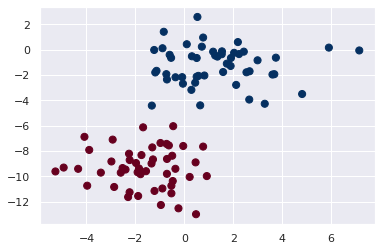

In [2]:
X, y = make_blobs(100,
                  centers=2,
                  random_state=2,
                  cluster_std=1.5
                 )

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

If we assume that points belonging to each class are generated from a gaussian distribution with no covariance between dimensions, (that is, the different features are independent between them) then we can easily approximate the generative distribution by computing the mean and the standard deviation of the points belonging to the two classes. The following function will plot the gaussian distributions fitted to the given points.

In [3]:
def plot_gaussian_distributions(X, y):
    fig, ax = plt.subplots()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
    ax.set_title('Naive Bayes Model', size=14)

    xlim = 1.1*np.array([X[:, 0].min(), X[:, 0].max()]) 
    ylim = 1.1*np.array([X[:, 1].min(), X[:, 1].max()])

    xg = np.linspace(xlim[0], xlim[1], 50)
    yg = np.linspace(ylim[0], ylim[1], 50)
    xx, yy = np.meshgrid(xg, yg)
    Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

    for label, color in enumerate(['red', 'blue']):
        mask = (y == label)
        mu, std = X[mask].mean(0), X[mask].std(0)
        P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
        ax.pcolorfast(xg, yg, P.reshape(xx.shape), alpha=0.5,
                      cmap=color.title() + 's')
        ax.contour(xx, yy, P.reshape(xx.shape),
                   levels=[0.01, 0.1, 0.5, 0.9],
                   colors=color, alpha=0.2)

    ax.set(xlim=xlim, ylim=ylim);

Plot the gaussian distributions

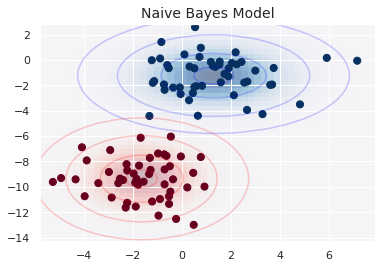

In [4]:
plot_gaussian_distributions(X, y)

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses. With this generative model in place for each class, we have a simple recipe to compute the likelihood $P(features | L_i)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn with `sklearn.naive_bayes.GaussianNB` estimator, import this model and fit it to the dataset we have generated.

In [5]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

Now generate some new data and use the model to predict the label. Generate points uniformly between (-6, 8) for the x axis and (-14, 4) for the y axis. Set `np.random.seed(0)`

In [6]:
np.random.seed(0)
Xnew = [-6, -14] + ([14, 18] * np.random.rand(2000, 2))

Now predict the label with the gaussian naive bayes's classifier.

In [7]:
ynew = model.predict(Xnew)

To get an idea of the decision boundary, plot the predictions with a scatter plot. Plot first the points of the training set and then plot the new generated points with `alpha=0.2`. What shape does the decision function follow?

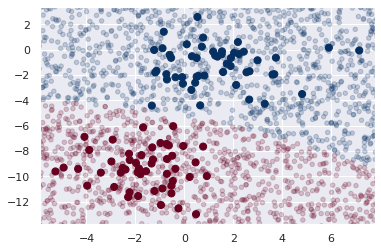

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.2)
plt.axis(lim);

Now generate a new model and change the priors, fit the model to the same training set and plot the prediction over the uniformly distributed data to see the decision function. How does the prior affect the decision?

In [9]:
model = GaussianNB(priors=[1E-9, 1 - 1E-9])
model.fit(X, y)

GaussianNB(priors=[1e-09, 0.999999999])

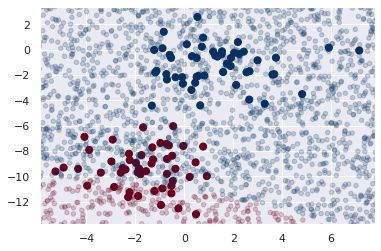

In [10]:
ynew = model.predict(Xnew)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.2)
plt.axis(lim);

An interesting property of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the `predict_proba` method. Use it to obtain the posterior probabilities of the uniformly distributed data. Use the model without predefined priors.

In [11]:
model = GaussianNB()
model.fit(X, y)

yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)


array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

Now represent the original training set and a heatmap of the posterior probabilities. You have to define a new function `plot_posterior_proba` that receives `X, y, model` and plots the points in `X` and a heatmap of the posterior probability. To do so you may reuse part of the code provided above to plot the gaussian distributions. Use the `cmap='jet'` with the `pcolorfast` method. And plot the posterior probability of class 0.

In [12]:
def plot_posterior_proba(X, y, model):

    xlim = 1.1*np.array([X[:, 0].min(), X[:, 0].max()]) 
    ylim = 1.1*np.array([X[:, 1].min(), X[:, 1].max()])

    fig, ax = plt.subplots()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
    ax.set_title('Posterior probability', size=14)

    xg = np.linspace(xlim[0], xlim[1], 50)
    yg = np.linspace(ylim[0], ylim[1], 50)
    xx, yy = np.meshgrid(xg, yg)
    Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

    yprob = model.predict_proba(Xgrid)

    ax.pcolorfast(xg, yg, yprob[:,0].reshape(xx.shape), alpha=0.5,
                  cmap='jet');

Plot the posterior probability. Is this shape expected? What observations do you have about the "border"?

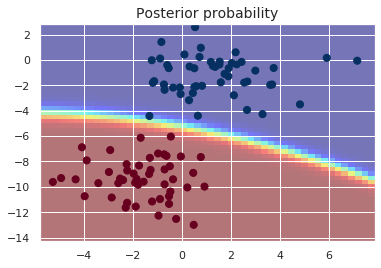

In [13]:
plot_posterior_proba(X, y, model)

Naive Bayes's classifier are very fast algorithms, and as we have seen, very robust to variations in the prior distributions. But what happens if the data does not follow exactly a gaussian distribution? Now generate a new dataset with `make_circles`. Generate 100 points with `factor=.1, noise=.2, random_state=0`

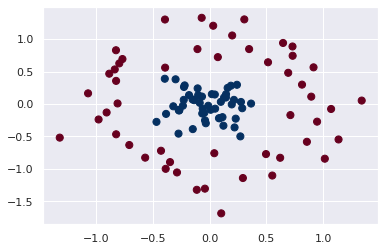

In [14]:
X, y = make_circles(100, factor=.1, noise=.2, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plt.show()

Fit a GaussianNB and plot the posterior probability. What do you observe? Was this expected?

In [15]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

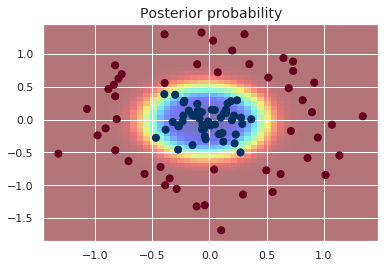

In [16]:
plot_posterior_proba(X, y, model)

Now plot the gaussian distributions fitted to this data. What shape do they have? Is the "naive" assumption correct?

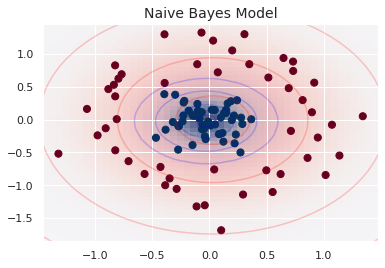

In [17]:
plot_gaussian_distributions(X, y)

Now generate a dataset which does not have "circular" classes. Use the `make_moons` method from sklearn with `noise=0.2`. Now fit another model an plot the posterior probability and the gaussian distributions.

In [18]:
X, y = make_moons(noise=0.2)

In [19]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

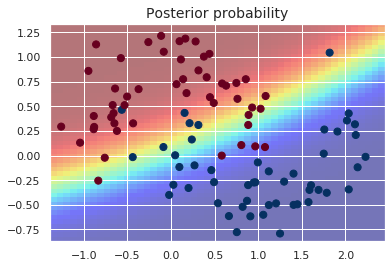

In [20]:
plot_posterior_proba(X, y, model)

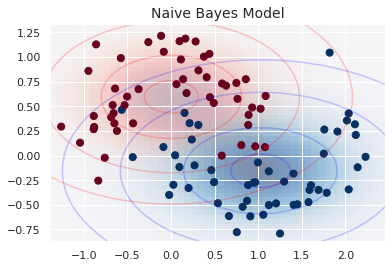

In [21]:
plot_gaussian_distributions(X, y)

## Multinomial  Bayes' classifier
The Gaussian assumption just described is not the only assumption that could be used about the generative distribution for each label. Another useful example is *multinomial naive Bayes*, where the features are assumed to be generated from a *multinomial distribution*. The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Example: Classifying text
One place where multinomial naive Bayes might be useful is in text classification, where the features are related to word counts or frequencies within the documents to be classified. Here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories. Let's download the data and take a look at the target names:

In [22]:
data = fetch_20newsgroups()

Print the dataset description

In [23]:
print(data.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

Print the target names

In [24]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set.

In [25]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)#, remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', categories=categories)#, remove=('headers', 'footers', 'quotes'))

Print the data from example number 6 in the training set (remember python starts counting from 0).

In [26]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer. The Term frequency-inverse document frequency (TF–IDF) which weights the word counts by a measure of how often they appear in the documents. We will compute the tf-idf and create a pipeline that attaches it to a multinomial naive Bayes classifier. 

Make a pipeline with the `TfidfVectorizer`and `MultinomialNB`

In [27]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, now apply it to the training data, and predict labels for the test data

In [28]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. Plot the confusion matrix of the predictions. Use the `confusion_matrix` from sklearn and the `sns.heatmap`. What can you say about this confusion matrix? Are all the classes equally well separated?

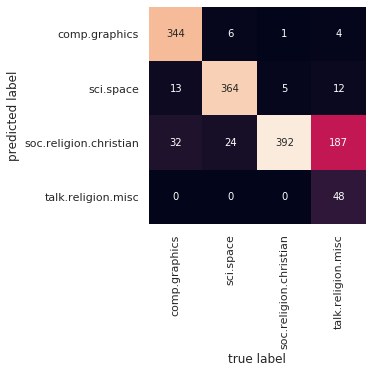

In [29]:
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

An interesting experiment that we can do now is to try to determine the category for any string, using this pipeline. This is a quick function that will return the prediction for a single string:

In [30]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Now try different sentences and see how are they classified.

In [31]:
predict_category('sending a payload to the ISS')

'sci.space'

In [32]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [33]:
predict_category('determining the screen resolution')

'comp.graphics'

In [34]:
predict_category('This rocket will take me to Mars')

'sci.space'

In [35]:
predict_category('This rocket will take me to God')

'soc.religion.christian'